# Playing Card Classifier

## Importing Libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator, array_to_img, load_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, UpSampling2D
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Conv2DTranspose, LeakyReLU
import os
from tqdm import tqdm
import keras
from keras.applications import ResNet50, VGG16
from skimage.io import imsave, imshow, imread
from skimage.color import rgb2gray, gray2rgb
import cv2 as cv
import matplotlib.pyplot as plt
import shutil
from PIL import Image
try :
    tf.config.experimental.set_memory_growth(tf.config.list_physical_devices()[2], True)
    print('GPU is in Play')
except:
    print('CPU is in Play')

GPU is in Play


## Usefull variables

In [2]:
eps = 250
BS = 32                          #Batch size
im_h = 86                   # Image Size
im_w = 96
dimension_img = (im_h, im_w, 3)

## Data Directory

In [3]:
train_dir = r'C:\Users\Lucifer MorningStar\Documents\Intern\train'
test_dir = r'C:\Users\Lucifer MorningStar\Documents\Intern\test'

## Data Augumentation

In [4]:
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2, brightness_range=(0.5, 1.5),
                                   horizontal_flip=True, vertical_flip = True, rotation_range = 90)

In [5]:
label = {}
i = 0
for img in tqdm(os.listdir(train_dir)):
    if img.endswith(('.jpg', '.png', '.jpg', '.jpeg')):
        file_name = img.split('.')[0]
        label[i] = file_name
        file_ext = '.' + (img.split('.')[1])
        imgs = cv.imread(train_dir+ '//' + img)
        imgs = rgb2gray(imgs)
        imgs = gray2rgb(imgs)
        imgs = cv.resize(imgs, (im_w, im_h))
        imgs = imgs.reshape((1,) + (dimension_img))
        train_datagen.fit(imgs)
        image_iterator = train_datagen.flow(imgs)
        i += 1
    
        for x in range(1500):
            img_transformed=image_iterator.next()[0]
            img_name = (str(i)+str(x)+ file_ext)
            try:
                im = array_to_img(img_transformed)
                im.save(train_dir + '//' + file_name + '//' + img_name)
            except:
                os.mkdir(train_dir + '//' + file_name)
                im = array_to_img(img_transformed)
                im.save(train_dir + '//' + file_name + '//' + img_name)

100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [08:03<00:00,  9.29s/it]


In [6]:
train_datagen = train_datagen = ImageDataGenerator(rescale=1./255, validation_split = 0.20)

## Loading The Generated Data

In [7]:
train = train_datagen.flow_from_directory(train_dir, target_size = (im_h, im_w), subset = 'training',
                                          classes = list(label.values()))

val = train_datagen.flow_from_directory(train_dir,target_size = (im_h, im_w), subset = 'validation',
                                        classes = list(label.values()))

Found 62400 images belonging to 52 classes.
Found 15600 images belonging to 52 classes.


## Defining Model Architecture

In [8]:
model = Sequential()
base = VGG16(include_top = False, input_shape = dimension_img)
for layer in base.layers:
    layer.trainable = False
    if str(layer).find('MaxPooling') > 0:
        model.add(BatchNormalization())
        model.add(layer)
    else:
        model.add(layer)

model.add(Flatten())  

model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(Activation('relu'))

model.add(Dense((train.num_classes)))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 86, 96, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 86, 96, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 86, 96, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 43, 48, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 43, 48, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 43, 48, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 43, 48, 128)       5

## Model Trainging

In [9]:
earlystoping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience = 5, verbose=0, mode='min',
  baseline=None, restore_best_weights=True)

model.fit(train, epochs = eps, callbacks = earlystoping, validation_data= (val), batch_size= BS, steps_per_epoch = 32,
         validation_steps = 20)

Epoch 1/250
32/32 [==============================] - 10s 313ms/step - loss: 4.0966 - accuracy: 0.0469 - val_loss: 3.9336 - val_accuracy: 0.0219
Epoch 2/250
32/32 [==============================] - 9s 292ms/step - loss: 3.6793 - accuracy: 0.0879 - val_loss: 3.8909 - val_accuracy: 0.0516
Epoch 3/250
32/32 [==============================] - 9s 292ms/step - loss: 3.2666 - accuracy: 0.1602 - val_loss: 3.8376 - val_accuracy: 0.0422
Epoch 4/250
32/32 [==============================] - 9s 283ms/step - loss: 2.7931 - accuracy: 0.2324 - val_loss: 3.6493 - val_accuracy: 0.1109
Epoch 5/250
32/32 [==============================] - 9s 275ms/step - loss: 2.3731 - accuracy: 0.3291 - val_loss: 3.4153 - val_accuracy: 0.1469
Epoch 6/250
32/32 [==============================] - 9s 267ms/step - loss: 2.0164 - accuracy: 0.3955 - val_loss: 3.2045 - val_accuracy: 0.1750
Epoch 7/250
32/32 [==============================] - 9s 268ms/step - loss: 1.7734 - accuracy: 0.4492 - val_loss: 2.8048 - val_accuracy: 0.256

## Random Preview of Model Prediction on Validation Data

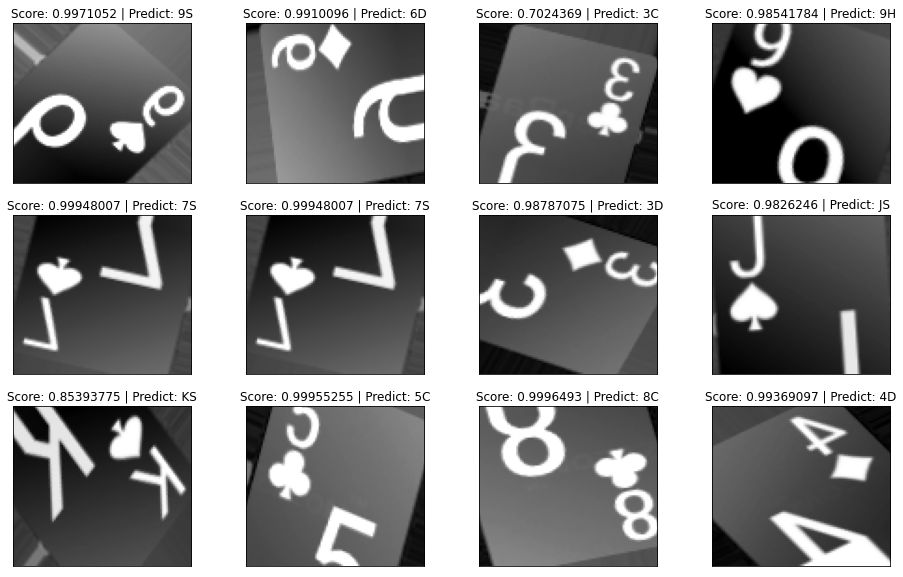

In [11]:
n = 12
plt.figure(figsize=(16, 10))
smp = np.random.randint(0, 32, n)
for i, im in enumerate(smp):
    plt.subplot(3, 4, i+1)
    test_img = val[0][0][im]
    plt.imshow(test_img)
    test_img = test_img.reshape((1,) + (im_h, im_w, 3))
    prob = (model.predict(test_img)).max()
    pred = model.predict_classes(test_img)[0]
    plt.xticks([])
    plt.yticks([])
    plt.title(('Score: '+str(prob) + ' | ' + 'Predict: ' + str(label[pred])))
plt.show()

## Random Preview of Model Prediction on Test Data

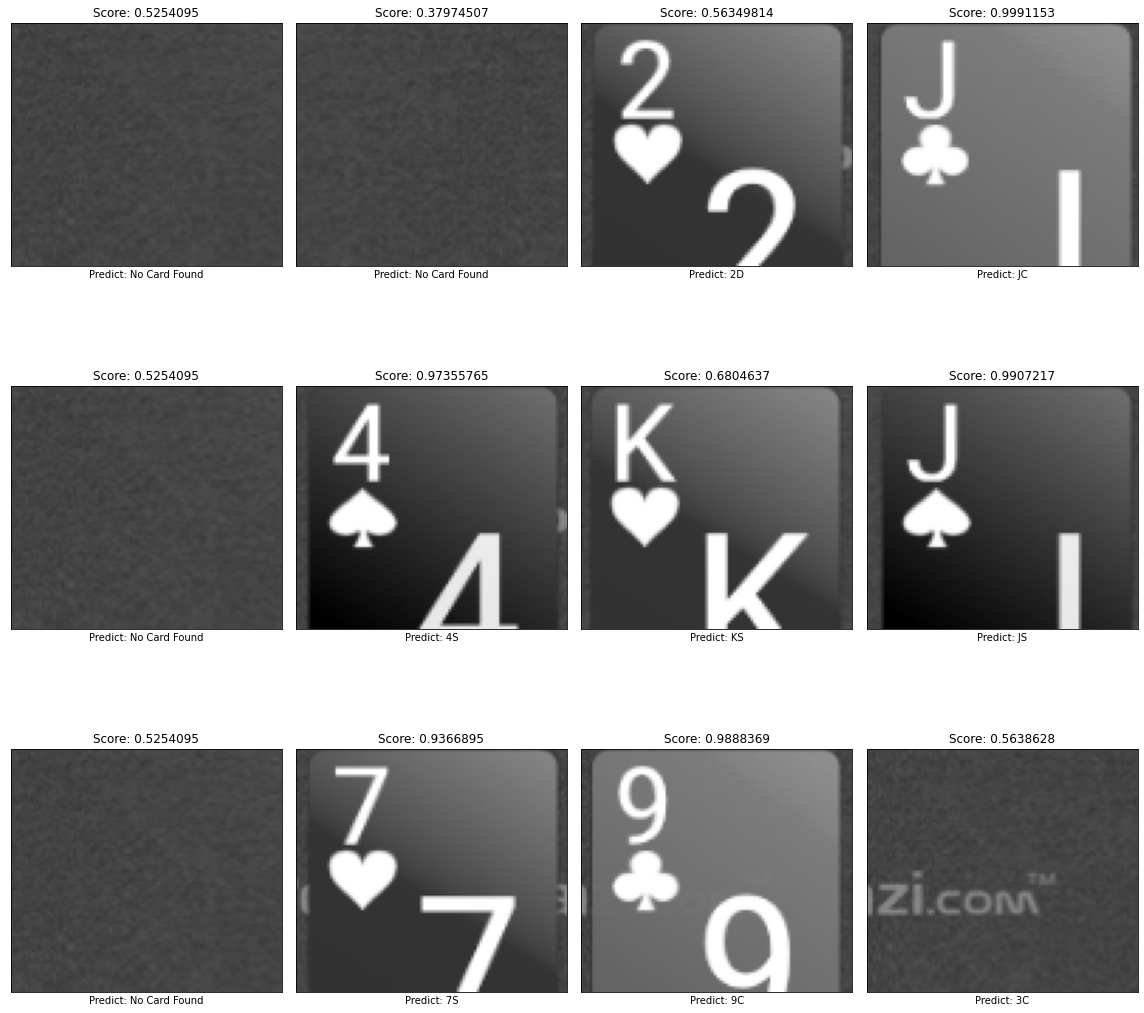

In [87]:
n = 12
plt.figure(figsize=(16, 16))
test = os.listdir(test_dir)
smp = np.random.randint(0, len(test), n)
for i, im in enumerate((smp)):
    plt.subplot(3, 4, i+1)
    path_test = os.path.join(test_dir, test[im])
    test_img = imread(path_test)/255
    test_img = rgb2gray(test_img)
    test_img = gray2rgb(test_img)
    plt.imshow(test_img)
    test_img = test_img.reshape((1,) + (im_h, im_w, 3))
    prob = model.predict_proba(test_img).max()
    pred = model.predict_classes(test_img)[0]
    if prob <= 0.53: # Creating a threshold to make prediction little more robust i.e to handle failure cases 
        plt.xlabel('Predict: ' + 'No Card Found')
    else:
        plt.xlabel('Predict: ' + str(label[pred]))
    plt.xticks([])
    plt.yticks([])
    plt.title(('Score: '+str(prob)))
plt.tight_layout()
plt.show()